# Chapter 30
## The PING Model of Gamma Rhythms
- Code by : [Abolfazl Ziaeemehr](https://github.com/Ziaeemehr)

In [1]:
import brian2 as b2
import matplotlib.pyplot as plt
import numpy as np
from input_factory import get_step_current

In [73]:
def plot_data(state_monitor, title=None, c='k'):
    """Plots the state_monitor variables "vm" vs. time.

    Args:
        state_monitor (StateMonitor): the data to plot
        title (string, optional): plot title to display
    """

    fig, ax = plt.subplots(2, figsize=(10, 6), sharex=True)

    
    ax[0].plot(state_monitor.t / b2.ms, state_monitor.vm[0] / b2.mV, lw=2, c="r", alpha=0.5)
    ax[0].plot(state_monitor.t / b2.ms, state_monitor.vm[1] / b2.mV, lw=2, c="b", alpha=0.5)
    ax[1].plot(state_monitor.t / b2.ms, state_monitor.s[0], lw=2, c="k")
    

    ax[0].set_xlabel("t [ms]")
    ax[0].set_ylabel("v [mV]")

    ax[0].set_xlim(0, np.max(state_monitor.t / b2.ms))
    ax[0].set_ylim(-100, 50)

    if title is not None:
        ax[0].set_title(title)

    plt.show();

In [75]:

def RTM_CELL(N, I_e, simulation_time):
    
    # neuron RTM parameters
    El = -67 * b2.mV
    EK = -100 * b2.mV
    ENa = 50 * b2.mV
    ESyn= 0 * b2.mV
    gl = 0.1 * b2.msiemens
    gK = 80 * b2.msiemens
    gNa = 100 * b2.msiemens
    
    C = 1 * b2.ufarad
    
    w = 1* b2.msiemens
    gSyn = 0.25 * b2.msiemens
    tau_d = 2 *b2.ms
    tau_r = 0.2 *b2.ms

    # forming RTM model with differential equations
    eqs = """

    alphah = 0.128 * exp(-(vm + 50.0*mV) / (18.0*mV))/ms :Hz
    alpham = 0.32/mV * (vm + 54*mV) / (1.0 - exp(-(vm + 54.0*mV) / (4.0*mV)))/ms:Hz
    alphan = 0.032/mV * (vm + 52*mV) / (1.0 - exp(-(vm + 52.0*mV) / (5.0*mV)))/ms:Hz

    betah  = 4.0 / (1.0 + exp(-(vm + 27.0*mV) / (5.0*mV)))/ms:Hz
    betam  = 0.28/mV * (vm + 27.0*mV) / (exp((vm + 27.0*mV) / (5.0*mV)) - 1.0)/ms:Hz
    betan  = 0.5 * exp(-(vm + 57.0*mV) / (40.0*mV))/ms:Hz

    membrane_Im = I_ext + gNa*m**3*h*(ENa-vm) + \
        gl*(El-vm) + gK*n**4*(EK-vm) + gSyn*s*(-vm): amp
    I_ext : amp

    dm/dt = alpham*(1-m)-betam*m : 1
    dn/dt = alphan*(1-n)-betan*n : 1
    dh/dt = alphah*(1-h)-betah*h : 1
    
    ds/dt = 0.5 * (1 + tanh(0.1*vm/mV)) * (1-s)/tau_r - s/tau_d : 1

    dvm/dt = membrane_Im/C : volt
    """

    neuron = b2.NeuronGroup(N, eqs, method="euler", 
                            dt=0.01*b2.ms,
                            threshold='vm>-55*mV')
    
    # initialize variables
    neuron.vm = [-70.0, -65.0]*b2.mV
    neuron.m = "alpham / (alpham + betam)"
    neuron.h = "alphah / (alphah + betah)"
    neuron.n = "alphan / (alphan + betan)"
    neuron.I_ext = [I_e, 0*b2.uA]
    
    S = b2.Synapses(neuron, neuron, on_pre='s += w')
    S.connect(i=0, j=1)
    

    # tracking variables
    st_mon = b2.StateMonitor(neuron, ["vm", "s"], record=[0,1])

    # running the simulation
    hh_net = b2.Network(neuron)
    hh_net.add(st_mon)
    hh_net.run(simulation_time)
    return st_mon

    


In [76]:
st = RTM_CELL(2, 1.5*b2.uA, 100*b2.ms)
# WB_CELL(1, 1.5*b2.uA, 100*b2.ms)

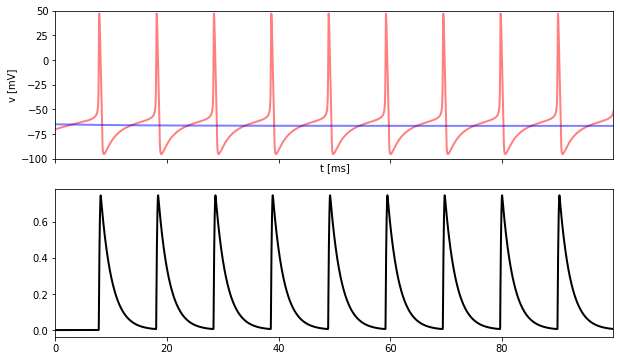

In [77]:
plot_data(st)